# Notebook to benchmark RAPIDS+Pytorch vs Huggingface tokenizer with Triton

This notebook calls a ensemble model which uses RAPIDS+Pytorch with Triton


<img src="notebook_images/ensemble_rapids_simple.jpg" width="300" height="400">

### Client Setup

In [1]:
# !pip install nvidia-pyindex
# !pip install tritonclient[all]

### Import Libraries

In [2]:
import numpy as np
import json

import grpc
from tritonclient.grpc import service_pb2
from tritonclient.grpc import service_pb2_grpc
import tritonclient.grpc as grpcclient
from functools import partial

###  Connect to the Triton End to End Model 

In [3]:
url='localhost:8001'

triton_client = grpcclient.InferenceServerClient(url=url,verbose=False)

channel = grpc.insecure_channel(url)
grpc_stub = service_pb2_grpc.GRPCInferenceServiceStub(channel)

In [4]:
#preprocessing_model = 'end_to_end_onnx'
#preprocessing_model = 'rapids_tokenizer'
preprocessing_model = 'end_to_end_pytorch_rapids'
request = service_pb2.ModelMetadataRequest(name=preprocessing_model,
                                           version='1')
response = grpc_stub.ModelMetadata(request)
print("model metadata:\n{}".format(response))

model metadata:
name: "end_to_end_pytorch_rapids"
versions: "1"
platform: "ensemble"
inputs {
  name: "product_reviews"
  datatype: "BYTES"
  shape: -1
  shape: -1
}
outputs {
  name: "preds"
  datatype: "INT32"
  shape: -1
  shape: -1
}



### Define functions for tokenization and end-to-end inference

In [5]:
def send_preprocess_request(log_ar, model_name='rapids_tokenizer'):
    triton_client = grpcclient.InferenceServerClient(url=url,verbose=False)
    input_grpc = grpcclient.InferInput("product_reviews",log_ar.shape,"BYTES")
    input_grpc.set_data_from_numpy(log_ar)

    outputs = []
    outputs.append(grpcclient.InferRequestedOutput('input_ids'))
    outputs.append(grpcclient.InferRequestedOutput('attention_mask'))

    
    output = triton_client.infer(model_name=model_name,
                               inputs=[input_grpc],
                              outputs=outputs)
    


    return output

In [6]:
def send_inference_request(log_ar, model_name='end_to_end_pytorch_rapids'):
    triton_client = grpcclient.InferenceServerClient(url=url,verbose=False)
    input_grpc = grpcclient.InferInput("product_reviews",log_ar.shape,"BYTES")
    input_grpc.set_data_from_numpy(log_ar)
    outputs = []
    outputs.append(grpcclient.InferRequestedOutput('preds'))
    
    output = triton_client.infer(model_name=model_name,
                               inputs=[input_grpc],
                              outputs=outputs)
    

    return output


## Test if the inference is correct with both tokenizers

##  Predictions

##### 1 is positive, 0 is negative

In [7]:
log_ls = ['The product is great', 'This product is bad','This product is good', 'This product is really bad']*1
log_ls = [l.encode('utf-8') for l in log_ls]
log_ar = np.array(log_ls).reshape(1,len(log_ls))
print(log_ar.shape, log_ar.squeeze().shape, type(log_ar))

(1, 4) (4,) <class 'numpy.ndarray'>


In [8]:
# RAPIDS
#output = send_inference_request(np.concatenate((log_ar,log_ar), axis=0).squeeze(),'end_to_end_pytorch_rapids')
output = send_inference_request(log_ar,'end_to_end_pytorch_rapids')
output.as_numpy('preds')

array([[1, 0, 1, 0]], dtype=int32)

In [9]:
# Huggingface
output = send_inference_request(log_ar,'end_to_end_pytorch_huggingface')
output.as_numpy('preds')

array([[1, 0, 1, 0]], dtype=int32)

## Benchmark RAPIDS vs Huggingface tokenizers

##### Utility functions from https://github.com/ELS-RD/transformer-deploy.git

In [75]:
import time
from contextlib import contextmanager
from typing import Dict, List, Tuple, Union
def print_timings(name: str, timings: List[float]) -> None:
    """
    Format and print inference latencies.
    :param name: inference engine name
    :param timings: latencies measured during the inference
    """
    mean_time = 1e3 * np.mean(timings)
    std_time = 1e3 * np.std(timings)
    min_time = 1e3 * np.min(timings)
    max_time = 1e3 * np.max(timings)
    median, percent_95_time, percent_99_time = 1e3 * np.percentile(timings, [50, 95, 99])
    print(
        f"[{name}] "
        f"mean={mean_time:.4f}ms, "
        f"sd={std_time:.2f}ms, "
        f"min={min_time:.2f}ms, "
        f"max={max_time:.2f}ms, "
        f"median={median:.2f}ms, "
        f"95p={percent_95_time:.2f}ms, "
        f"99p={percent_99_time:.2f}ms"
    )

@contextmanager
def track_infer_time(buffer: List[int]) -> None:
    """
    A context manager to perform latency measures
    :param buffer: a List where to save latencies for each input
    """
    start = time.perf_counter()
    yield
    end = time.perf_counter()
    buffer.append(end - start)

### Prepare Input 
##### Generate input of variable number of sequences and seq length

In [11]:
def prepare_input(sentence='This product is great', lenfac=100, num_seq=100):

    log_txt = sentence * lenfac
    log_ls = [log_txt] * num_seq
    log_ls = [l.encode('utf-8') for l in log_ls]
    
    return np.array(log_ls).reshape(1,len(log_ls))

In [12]:
log_ar = prepare_input(sentence='This product is great', lenfac=1, num_seq=10)

output = send_preprocess_request(log_ar.squeeze(), model_name="rapids_tokenizer")
send_inference_request(log_ar, model_name="end_to_end_pytorch_rapids")


In [13]:
output.as_numpy('input_ids').shape

(10, 256)

### Prepare Input 
##### Randomly selected 100 rows from Gutenburg

In [14]:
data='''This text is included to make sure Unicode is handled properly: 力加勝北区ᴵᴺᵀᵃছজটডণত
This sample text is public domain and was randomly selected from Project Guttenberg.
The rain had only ceased with the gray streaks of morning at Blazing Star, and the settlement awoke to a moral sense of cleanliness, and the finding of forgotten knives, tin cups, and smaller camp utensils, where the heavy showers had washed away the debris and dust heaps before the cabin doors.
Indeed, it was recorded in Blazing Star that a fortunate early riser had once picked up on the highway a solid chunk of gold quartz which the rain had freed from its incumbering soil, and washed into immediate and glittering popularity.
Possibly this may have been the reason why early risers in that locality, during the rainy season, adopted a thoughtful habit of body, and seldom lifted their eyes to the rifted or india-ink washed skies above them.
"Cass" Beard had risen early that morning, but not with a view to discovery.
A leak in his cabin roof,--quite consistent with his careless, improvident habits,--had roused him at 4 A. M., with a flooded "bunk" and wet blankets.
The chips from his wood pile refused to kindle a fire to dry his bed-clothes, and he had recourse to a more provident neighbor's to supply the deficiency.
This was nearly opposite.
Mr. Cassius crossed the highway, and stopped suddenly.
But the Goblin could no longer sit quietly listening to the wisdom and intellect downstairs. No, as soon as the light shone in the evening from the attic it seemed to him as though its beams were strong ropes dragging him up, and he had to go and peep through the key-hole. There he felt the sort of feeling we have looking at the great rolling sea in a storm, and he burst into tears. He could not himself say why he wept, but in spite of his tears he felt quite happy. How beautiful it must be to sit under that tree with the student, but that he could not do; he had to content himself with the key-hole and be happy there!
But, wonderful to relate, not an irregular, shapeless fragment of crude ore, fresh from Nature's crucible, but a bit of jeweler's handicraft in the form of a plain gold ring.
Looking at it more attentively, he saw that it bore the inscription, "May to Cass."
Like most of his fellow gold-seekers, Cass was superstitious.
The fountain of classic wisdom, Hypatia herself.
As the ancient sage--the name is unimportant to a monk--pumped water nightly that he might study by day, so I, the guardian of cloaks and parasols, at the sacred doors of her lecture-room, imbibe celestial knowledge.
From my youth I felt in me a soul above the matter-entangled herd.
She revealed to me the glorious fact, that I am a spark of Divinity itself.
A fallen star, I am, sir!' continued he, pensively, stroking his lean stomach--'a fallen star!--fallen, if the dignity of philosophy will allow of the simile, among the hogs of the lower world--indeed, even into the hog-bucket itself. Well, after all, I will show you the way to the Archbishop's.
There is a philosophic pleasure in opening one's treasures to the modest young.
Perhaps you will assist me by carrying this basket of fruit?' And the little man jumped up, put his basket on Philammon's head, and trotted off up a neighbouring street.
Philammon followed, half contemptuous, half wondering at what this philosophy might be, which could feed the self-conceit of anything so abject as his ragged little apish guide;
but the novel roar and whirl of the street, the perpetual stream of busy faces, the line of curricles, palanquins, laden asses, camels, elephants, which met and passed him, and squeezed him up steps and into doorways, as they threaded their way through the great Moon-gate into the ample street beyond, drove everything from his mind but wondering curiosity, and a vague, helpless dread of that great living wilderness, more terrible than any dead wilderness of sand which he had left behind.
Already he longed for the repose, the silence of the Laura--for faces which knew him and smiled upon him; but it was too late to turn back now.
His guide held on for more than a mile up the great main street, crossed in the centre of the city, at right angles, by one equally magnificent, at each end of which, miles away, appeared, dim and distant over the heads of the living stream of passengers, the yellow sand-hills of the desert;
while at the end of the vista in front of them gleamed the blue harbour, through a network of countless masts.
At last they reached the quay at the opposite end of the street;
and there burst on Philammon's astonished eyes a vast semicircle of blue sea, ringed with palaces and towers.
He stopped involuntarily; and his little guide stopped also, and looked askance at the young monk, to watch the effect which that grand panorama should produce on him.
Nana also troubled him in another way. He had sometimes a feeling that she did not admire him. “I know she admires you tremendously, George,”
Mrs. Darling would assure him, and then she would sign to the children to be specially nice to father. Lovely dances followed, in which the only other servant, Liza, was sometimes allowed to join. 
Such a midget she looked in her long skirt and maid's cap, though she had sworn, when engaged, that she would never see ten again. 
The gaiety of those romps!
And gayest of all was Mrs. Darling, who would pirouette so wildly that all you could see of her was the kiss, and then if you had dashed at her you might have got it. 
There never was a simpler happier family until the coming of Peter Pan.
Finally, I always go to sea as a sailor, because of the wholesome exercise and pure air of the fore-castle deck. 
For as in this world, head winds are far more prevalent than winds from astern (that is, if you never violate the Pythagorean maxim), so for the most part the Commodore on the quarter-deck gets his atmosphere at second hand from the sailors on the forecastle. He thinks he breathes it first; but not so. 
In much the same way do the commonalty lead their leaders in many other things, at the same time that the leaders little suspect it. 
But wherefore it was that after having repeatedly smelt the sea as a merchant sailor, I should now take it into my head to go on a whaling voyage; this the invisible police officer of the Fates, who has the constant surveillance of me, and secretly dogs me, and influences me in some unaccountable way—he can better answer than any one else. 
And, doubtless, my going on this whaling voyage, formed part of the grand programme of Providence that was drawn up a long time ago. 
It came in as a sort of brief interlude and solo between more extensive performances. 
I take it that this part of the bill must have run something like this:
“_Grand Contested Election for the Presidency of the United States._
“WHALING VOYAGE BY ONE ISHMAEL. “BLOODY BATTLE IN AFFGHANISTAN.”
Amy followed, but she poked her hands out stiffly before her, and jerked herself along as if she went by machinery, and her "Ow!" was more suggestive of pins being run into her than of fear and anguish.
Jo gave a despairing groan, and Meg laughed outright, while Beth let her bread burn as she watched the fun with interest. 
"It's no use!  Do the best you can when the time comes, and if the audience laughs, don't blame me.  Come on, Meg."
Then things went smoothly, for Don Pedro defied the world in a speech of two pages without a single break.  Hagar, the witch, chanted an awful incantation over her kettleful of simmering toads, with weird effect.  
Roderigo rent his chains asunder manfully, and Hugo died in agonies of remorse and arsenic, with a wild, "Ha! Ha!"
This text is included to make sure Unicode is handled properly: 力加勝北区ᴵᴺᵀᵃছজটডণত
This sample text is public domain and was randomly selected from Project Guttenberg.
The rain had only ceased with the gray streaks of morning at Blazing Star, and the settlement awoke to a moral sense of cleanliness, and the finding of forgotten knives, tin cups, and smaller camp utensils, where the heavy showers had washed away the debris and dust heaps before the cabin doors.
Indeed, it was recorded in Blazing Star that a fortunate early riser had once picked up on the highway a solid chunk of gold quartz which the rain had freed from its incumbering soil, and washed into immediate and glittering popularity.
Possibly this may have been the reason why early risers in that locality, during the rainy season, adopted a thoughtful habit of body, and seldom lifted their eyes to the rifted or india-ink washed skies above them.
"Cass" Beard had risen early that morning, but not with a view to discovery.
A leak in his cabin roof,--quite consistent with his careless, improvident habits,--had roused him at 4 A. M., with a flooded "bunk" and wet blankets.
The chips from his wood pile refused to kindle a fire to dry his bed-clothes, and he had recourse to a more provident neighbor's to supply the deficiency.
This was nearly opposite.
Mr. Cassius crossed the highway, and stopped suddenly.
Something glittered in the nearest red pool before him.
I had one experience with Master Philip before our visitors betook themselves back to Kent, which, unfortunate as it was, I cannot but relate here. My cousin would enter into none of those rough amusements in which I passed my time, for fear, I took it, of spoiling his fine broadcloths or of losing a gold buckle. He never could be got to wrestle, though I challenged him more than once. And he was a well-built lad, and might, with a little practice, have become skilled in that sport. He laughed at the homespun I wore about the farm, saying it was no costume for a gentleman's son, and begged me sneeringly to don leather breeches. He would have none of the company of those lads with whom I found pleasure, young Harvey, and Willis's son, who was being trained as Mr. Starkie's assistant. Nor indeed did I disdain to join in a game with Hugo, who had been given to me, and other negro lads. Philip saw no sport in a wrestle or a fight between two of the boys from the quarters, and marvelled that I could lower myself to bet with Harvey the younger. He took not a spark of interest in the gaming cocks we raised together to compete at the local contests and at the fair, and knew not a gaff from a cockspur. Being one day at my wits' end to amuse my cousin, I proposed to him a game of quoits on the green beside the spring-house, and thither we repaired, followed by Hugo, and young Harvey come to look on. Master Philip, not casting as well as he might, cries out suddenly to Hugo: "Begone, you black dog! What business have you here watching a game between gentlemen?"
But, wonderful to relate, not an irregular, shapeless fragment of crude ore, fresh from Nature's crucible, but a bit of jeweler's handicraft in the form of a plain gold ring.
Looking at it more attentively, he saw that it bore the inscription, "May to Cass."
Like most of his fellow gold-seekers, Cass was superstitious.
The fountain of classic wisdom, Hypatia herself.
As the ancient sage--the name is unimportant to a monk--pumped water nightly that he might study by day, so I, the guardian of cloaks and parasols, at the sacred doors of her lecture-room, imbibe celestial knowledge.
From my youth I felt in me a soul above the matter-entangled herd.
She revealed to me the glorious fact, that I am a spark of Divinity itself.
A fallen star, I am, sir!' continued he, pensively, stroking his lean stomach--'a fallen star!--fallen, if the dignity of philosophy will allow of the simile, among the hogs of the lower world--indeed, even into the hog-bucket itself. Well, after all, I will show you the way to the Archbishop's.
There is a philosophic pleasure in opening one's treasures to the modest young.
Perhaps you will assist me by carrying this basket of fruit?' And the little man jumped up, put his basket on Philammon's head, and trotted off up a neighbouring street.
Philammon followed, half contemptuous, half wondering at what this philosophy might be, which could feed the self-conceit of anything so abject as his ragged little apish guide;
but the novel roar and whirl of the street, the perpetual stream of busy faces, the line of curricles, palanquins, laden asses, camels, elephants, which met and passed him, and squeezed him up steps and into doorways, as they threaded their way through the great Moon-gate into the ample street beyond, drove everything from his mind but wondering curiosity, and a vague, helpless dread of that great living wilderness, more terrible than any dead wilderness of sand which he had left behind.
Already he longed for the repose, the silence of the Laura--for faces which knew him and smiled upon him; but it was too late to turn back now.
His guide held on for more than a mile up the great main street, crossed in the centre of the city, at right angles, by one equally magnificent, at each end of which, miles away, appeared, dim and distant over the heads of the living stream of passengers, the yellow sand-hills of the desert;
while at the end of the vista in front of them gleamed the blue harbour, through a network of countless masts.
and there burst on Philammon's astonished eyes a vast semicircle of blue sea, ringed with palaces and towers.
He stopped involuntarily; and his little guide stopped also, and looked askance at the young monk, to watch the effect which that grand panorama should produce on him.
Nana also troubled him in another way. He had sometimes a feeling that she did not admire him. “I know she admires you tremendously, George,”
Mrs. Darling would assure him, and then she would sign to the children to be specially nice to father. Lovely dances followed, in which the only other servant, Liza, was sometimes allowed to join. 
Such a midget she looked in her long skirt and maid's cap, though she had sworn, when engaged, that she would never see ten again. 
In the Year 1676, the Prince of _Orange_ having, in concert with the _Spaniards_, resolv'd upon the important Siege of _Maestrich_ (the only Town in the _Dutch_ Provinces, then remaining in the Hands of the _French_) it was accordingly invested about the middle of _June_, with an Army of twenty Thousand Men, under the Command of his Highness Prince
_Waldeck_, with the grand Army covering the Siege. It was some Time before the heavy Cannon, which we expected up the _Maes_, from _Holland_, arrived; which gave Occasion to a Piece of Raillery of Monsieur _Calvo_, the Governor, which was as handsomely repartec'd. That Governor, by a Messenger, intimating his Sorrow to find, we had pawn'd our Cannon for Ammunition Bread. Answer was made, That in a few Days we hoped to give him a Taste of the Loaves, which he should find would be sent him into the Town in extraordinary plenty. I remember another Piece of Raillery, which pass'd some Days after between the _Rhingrave_ and the same _Calvo_. The former sending Word, that he hoped within three Weeks to salute that Governor's Mistress within the Place. _Calvo_ reply'd, He'd give him leave to kiss her all over, if he kiss'd her anywhere in three Months.
And gayest of all was Mrs. Darling, who would pirouette so wildly that all you could see of her was the kiss, and then if you had dashed at her you might have got it. 
There never was a simpler happier family until the coming of Peter Pan.
Finally, I always go to sea as a sailor, because of the wholesome exercise and pure air of the fore-castle deck. 
For as in this world, head winds are far more prevalent than winds from astern (that is, if you never violate the Pythagorean maxim), so for the most part the Commodore on the quarter-deck gets his atmosphere at second hand from the sailors on the forecastle. He thinks he breathes it first; but not so. 
In much the same way do the commonalty lead their leaders in many other things, at the same time that the leaders little suspect it. 
But wherefore it was that after having repeatedly smelt the sea as a merchant sailor, I should now take it into my head to go on a whaling voyage; this the invisible police officer of the Fates, who has the constant surveillance of me, and secretly dogs me, and influences me in some unaccountable way—he can better answer than any one else. 
And, doubtless, my going on this whaling voyage, formed part of the grand programme of Providence that was drawn up a long time ago. 
It came in as a sort of brief interlude and solo between more extensive performances. 
The British Isles have been ringing for the last few years with the word 'Art' in its German sense; with 'High Art,' 'Symbolic Art,' 'Ecclesiastical Art,' 'Dramatic Art,' 'Tragic Art,' and so forth; and every well-educated person is expected, nowadays, to know something about Art.  Yet in spite of all translations of German 'AEsthetic' treatises, and 'Kunstnovellen,' the mass of the British people cares very little about the matter, and sits contented under the imputation of 'bad taste.'  Our stage, long since dead, does not revive; our poetry is dying; our music, like our architecture, only reproduces the past; our painting is only first-rate when it handles landscapes and animals, and seems likely so to remain; but, meanwhile, nobody cares.  Some of the deepest and most earnest minds vote the question, in general, a 'sham and a snare,' and whisper to each other
confidentially, that Gothic art is beginning to be a 'bore,' and that Sir Christopher Wren was a very good fellow after all; while the middle classes look on the Art movement half amused, as with a pretty toy, half sulkily suspicious of Popery and Paganism, and think,
apparently, that Art is very well when it means nothing, and is merely used to beautify drawing-rooms and shawl patterns; not to mention that, if there were no painters, Mr. Smith could not hand down to posterity likenesses of himself, Mrs. Smith, and family.  But
when 'Art' dares to be in earnest, and to mean something, much more to connect itself with religion, Smith's tone alters.  He will teach 'Art' to keep in what he considers its place, and if it refuses, take the law of it, and put it into the Ecclesiastical Court.  So he says, and what is more, he means what he says; and as all the world, from Hindostan to Canada, knows by most practical proof, what he means, he sooner or later does, perhaps not always in the wisest way, but still he does it.Ah!  It's pleasant to drop into my own easy-chair my dear though a little palpitating what with trotting up-stairs and what with trotting down, and why kitchen stairs should all be corner stairs is for the builders to justify though I do not think they fully understand their trade and never did, else why the sameness and why not more conveniences and fewer
draughts and likewise making a practice of laying the plaster on too thick I am well convinced which holds the damp, and as to chimney-pots putting them on by guess-work like hats at a party and no more knowing what their effect will be upon the smoke bless you than I do if so much, except that it will mostly be either to send it down your throat in a straight form or give it a twist before it goes there.  And what I says speaking as I find of those new metal chimneys all manner of shapes (there's a row of 'em at Miss Wozenham's lodging-house lower down on the other side of the way) is that they only work your smoke into artificial patterns for you before you swallow it and that I'd quite as soon swallow mine plain, the flavour being the same, not to mention the conceit of putting up signs on the top of your house to show the forms in which you take your smoke into your inside
Amy followed, but she poked her hands out stiffly before her, and jerked herself along as if she went by machinery, and her "Ow!" was more suggestive of pins being run into her than of fear and anguish.
Jo gave a despairing groan, and Meg laughed outright, while Beth let her bread burn as she watched the fun with interest. 
"It's no use!  Do the best you can when the time comes, and if the audience laughs, don't blame me.  Come on, Meg."
Then things went smoothly, for Don Pedro defied the world in a speech of two pages without a single break.  Hagar, the witch, chanted an awful incantation over her kettleful of simmering toads, with weird effect.'''

In [15]:
txt_ls = data.split('\n')
txt_ls  = txt_ls[0:100]
print("Benchmarking on number of sentences = {:,}".format(len(txt_ls)))

Benchmarking on number of sentences = 100


In [16]:
txt_ls = [l.encode('utf-8') for l in txt_ls]
txt_ar = np.array(txt_ls).reshape(1,len(txt_ls))

In [17]:
output = send_preprocess_request(txt_ar.squeeze(), model_name="rapids_tokenizer")

### Run the benchmark: with procedurally generated data

In [36]:
# dictionary for the benchmark results
results = {}

# Sequence length
lenfac = 64 # seq_length is 256

# Benchmark parameters
num_warmup_runs = 10
num_bench_runs = 100

num_seqs= [2, 10, 100, 1000] # number of sequences to proces

# Run a preprocess (tokenization) or an end-to-end inference request
modes = ["preprocess", "inference"] # do not put this in the loop to avoid if conditions

# Backends to try: cudf (RAPIDS) vs hugf (Hugging Face)
backends = ["rapids", "huggingface"]

for num_seq in num_seqs:
    # Input for the current benchmark
    #log_ar = prepare_input(lenfac=lenfac, num_seq=num_seq)
    log_ar = prepare_input(lenfac=lenfac, num_seq=num_seq)
    
    for backend in backends:
        
        # Preprocessing
        mode = modes[0]
        tag = "{}_{}_{}".format(mode, backend, num_seq)  
        model_name = "{}_tokenizer".format(backend)
        
        # Warm up
        for _ in range(num_warmup_runs):
            output = send_preprocess_request(log_ar.squeeze(), model_name=model_name)

        # Benchmark
        time_buffer = []        
        for _ in range(num_bench_runs):
            with track_infer_time(time_buffer):                
                output = send_preprocess_request(log_ar.squeeze(), model_name=model_name)
        results[tag] = time_buffer

        # Inference
        mode = modes[1]
        tag = "{}_{}_{}".format(mode, backend, num_seq)            
        model_name = "end_to_end_pytorch_{}".format(backend)
        
        # Warm up
        for _ in range(num_warmup_runs):
            output = send_inference_request(log_ar, model_name=model_name)
        
        # Benchmark
        time_buffer = []
        for _ in range(num_bench_runs):
            with track_infer_time(time_buffer):
                output = send_inference_request(log_ar, model_name=model_name)
        results[tag] = time_buffer        

In [76]:
for name, time_buffer in results.items():
    print_timings(name=name, timings=time_buffer)

[preprocess_rapids_2] mean=4.3768ms, sd=0.19ms, min=4.02ms, max=4.62ms, median=4.45ms, 95p=4.59ms, 99p=4.61ms
[inference_rapids_2] mean=28.4526ms, sd=2.30ms, min=24.93ms, max=31.95ms, median=28.22ms, 95p=31.50ms, 99p=31.86ms
[preprocess_huggingface_2] mean=4.7406ms, sd=0.31ms, min=4.19ms, max=5.32ms, median=4.74ms, 95p=5.22ms, 99p=5.30ms
[inference_huggingface_2] mean=26.7186ms, sd=1.95ms, min=25.05ms, max=30.14ms, median=25.59ms, 95p=29.99ms, 99p=30.11ms
[preprocess_rapids_10] mean=5.6325ms, sd=0.43ms, min=4.91ms, max=6.21ms, median=5.55ms, 95p=6.20ms, 99p=6.20ms
[inference_rapids_10] mean=50.7605ms, sd=0.40ms, min=49.88ms, max=51.25ms, median=50.86ms, 95p=51.16ms, 99p=51.23ms
[preprocess_huggingface_10] mean=7.4250ms, sd=0.63ms, min=6.49ms, max=8.50ms, median=7.35ms, 95p=8.50ms, 99p=8.50ms
[inference_huggingface_10] mean=51.4114ms, sd=0.45ms, min=50.42ms, max=52.26ms, median=51.47ms, 95p=51.99ms, 99p=52.21ms
[preprocess_rapids_100] mean=9.1801ms, sd=0.60ms, min=8.03ms, max=9.85ms, me

In [98]:
# prepare the plot data
times = 1e3 * np.mean(np.array(list(results.values())), axis=1).reshape((8,2))
rapids_pre_times = times[::2, 0].reshape((-1,1))
rapids_inf_times = times[::2, 1].reshape((-1,1))
huggingface_pre_times = times[1::2, 0].reshape((-1,1))
huggingface_inf_times = times[1::2, 1].reshape((-1,1))    

In [341]:
import matplotlib.pyplot as plt

def plot_results(data, num_seqs, val_range, title='cuDF vs Huggingface', columns = ('Hugging Face', 'RAPIDS'), legend=['Hugging Face', 'cuDF'], figsize=(8,6), dpi=150):
    from matplotlib.pyplot import figure
    
    figure(figsize=figsize, dpi=dpi)

    dataf = np.flip(data, axis=0)
    
    columns = columns
    rows =  ['batch_size: %d' % num_seq for num_seq in num_seqs]

    
    values = val_range 
    #values = np.arange(0, np.amax(data), np.amax(data)/10)
    value_increment = 1

    # Get some pastel shades for the colors
    colors = plt.cm.RdBu(np.linspace(0.15, 0.95, len(rows)))
    n_rows = len(data)
  
    index = np.arange(len(columns)) + 0.3
    bar_width = 0.4


    # Initialize the vertical-offset for the stacked bar chart.
    y_offset = np.zeros(len(columns))
    
    plt.plot(np.arange(0, n_rows), data[:, 0], 'r-', alpha=0.25)
    plt.plot(np.arange(0, n_rows), data[:, 1], 'b-', alpha=0.25)
    plt.grid(alpha=0.5)
    # Plot bars and create text labels for the table
    cell_text = []
    for row in range(n_rows):
        #plt.bar(index, data[row], bar_width, bottom=y_offset, color=colors[row])
        plt.plot(row, data[row, 0], 'r.', markersize=12)
        plt.plot(row, data[row, 1], 'b.', markersize=12)
        
        #cell_text.append(['%.2f' % (x) for x in y_offset])
        cell_text.append(['%.2f ms' % (x) for x in dataf[row]])
    # Reverse colors and text labels to display the last value at the top.
    colors = colors[::-1]
    cell_text.reverse()

    # Add a table at the bottom of the axes
    the_table = plt.table(cellText=cell_text,
                          rowLabels=rows,
                          rowColours=colors,
                          colLabels=columns,
                          loc='bottom')

    the_table.set_fontsize(7)

    # Adjust layout to make room for the table:
    plt.subplots_adjust(left=0.2, bottom=0.2)

    plt.ylabel("Time (ms)", fontsize=10)
    plt.yticks(values * value_increment, ['%d' % val for val in values])
    plt.xticks([])
    plt.title(title, fontsize=8, fontweight='bold')
    

    from matplotlib.font_manager import FontProperties
    # Make table labels bold
    for (row, col), cell in the_table.get_celld().items():
        if (row == 0) or (col == -1):
            cell.set_text_props(fontproperties=FontProperties(weight='bold'))

    plt.legend(legend, fontsize=6.5)
    plt.show()

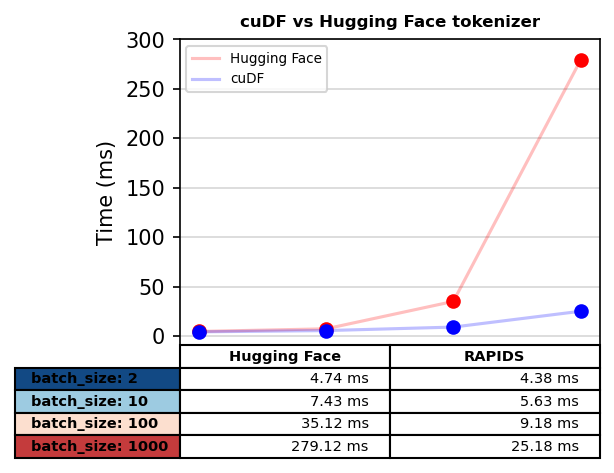

In [346]:

value_range = np.arange(0, 350, 50)
plotdata_pre = np.concatenate((huggingface_pre_times, rapids_pre_times), axis=1)
title = 'cuDF vs Hugging Face tokenizer'
columns = ('Hugging Face', 'RAPIDS')
legend=['Hugging Face', 'cuDF']
plot_results(plotdata_pre, num_seqs, value_range, title, columns, legend, figsize=(4,3))

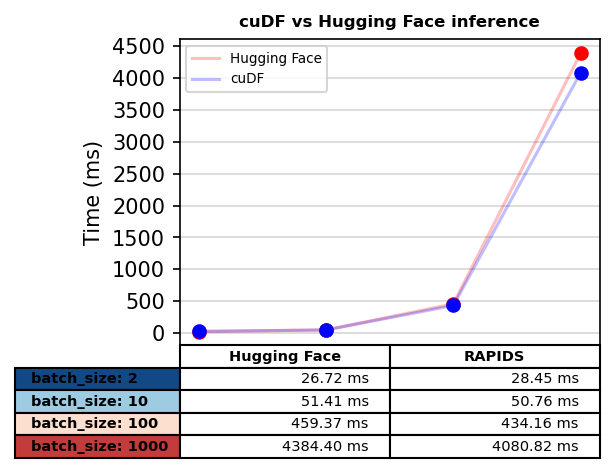

In [347]:
value_range = np.arange(0, 5000, 500)
plotdata_inf = np.concatenate((huggingface_inf_times, rapids_inf_times), axis=1)
title = 'cuDF vs Hugging Face inference'
columns = ('Hugging Face', 'RAPIDS')
plot_results(plotdata_inf, num_seqs, value_range, title, columns, legend, figsize=(4,3))

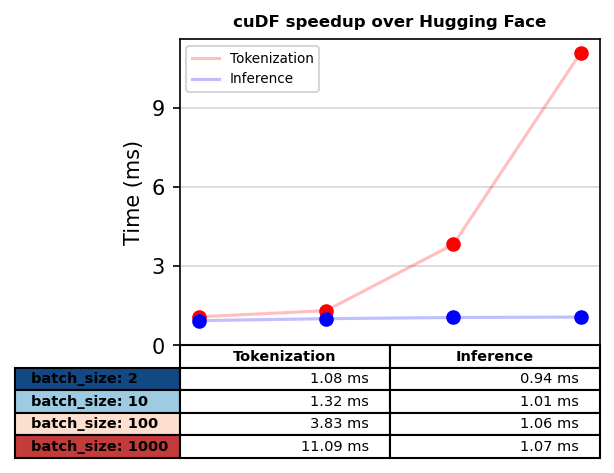

In [348]:
value_range = np.arange(0, 12, 3)
speedups = np.concatenate(((huggingface_pre_times/rapids_pre_times).reshape(-1,1), (huggingface_inf_times/rapids_inf_times).reshape(-1,1)), axis=1)
columns = ('Tokenization', 'Inference')
title = 'cuDF speedup over Hugging Face'
legend=['Tokenization', 'Inference']
plot_results(speedups, num_seqs, value_range, title, columns, legend, figsize=(4,3))